# Определение перспективного тарифа для телеком-компании

# Содержание

**Получение данных** 

**Подготовка данных** 

    Приведение данных к нужным типам 

    Исправление ошибок в данных 

    Расчеты для каждого пользователя: 

       Количество сделанных звонков и израсходованных минут разговора по месяцам 

       Количество отправленных сообщений по месяцам 

       Объем израсходованного интернет-трафика по месяцам 

       Помесячная выручка с каждого пользователя 

**Анализ данных выборки по каждому тарифу** 

**Проверка гипотез** 

**Вывод** 


# Описание проекта

Заказчик исследования — федеральный оператор сотовой связи «Мегалайн». 

Цель исследования — определить, какой из двух тарифов приносит больше денег: «Смарт» и «Ультра». 

Данные для исследования — небольшая выборка из 500 клиентов, содержащая следующую информацию: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

ОПИСАНИЕ ТАРИФОВ

**Тариф «Смарт»:**
- Ежемесячная плата: 550 рублей;
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика;
- Стоимость услуг сверх тарифного пакета: минута разговора 3 рубля, сообщение 3 рубля, 1 Гб интернет-трафика 200 рублей.

**Тариф «Ультра»:**
- Ежемесячная плата: 1950 рублей;
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика;
- Стоимость услуг сверх тарифного пакета: минута разговора 1 рубль, сообщение 1 рубль, 1 Гб интернет-трафика 150 рублей.

*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.*

## Получение данных

In [1]:
# Импорт библиотек:
import pandas as pd
import numpy as np
from scipy import stats as st
import plotly.express as px
import math
import matplotlib.pyplot as plt
import seaborn as sns

### Информация о звонках

In [2]:
try:
    calls = pd.read_csv('C:/datasets/yandex_projects/telecom/calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls содержит следующую информацию:
- id — уникальный номер звонка;
- call_date — дата звонка;
- duration — длительность звонка в минутах;
- user_id — идентификатор пользователя, сделавшего звонок.

Видим, что в датасете присутстуют звонки с нулевой продолжительностью. Известно, что это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

### Информация об интернет-сессиях

In [4]:
try:
    internet = pd.read_csv('C:/datasets/yandex_projects/telecom/internet.csv')
except:
    internet = pd.read_csv('/datasets/internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица internet:
- id — уникальный номер сессии;
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
- session_date — дата интернет-сессии;
- user_id — идентификатор пользователя.

### Информация  о сообщениях

In [6]:
try:
    messages = pd.read_csv('C:/datasets/yandex_projects/telecom/messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages:
- id — уникальный номер сообщения;
- message_date — дата сообщения;
- user_id — идентификатор пользователя, отправившего сообщение.

### Информация о тарифах

In [8]:
try:
    tariffs = pd.read_csv('C:/datasets/yandex_projects/telecom/tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [9]:
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs:
- tariff_name — название тарифа;
- rub_monthly_fee — ежемесячная абонентская плата в рублях;
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
- messages_included — количество сообщений в месяц, включённых в абонентскую плату;
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

In [10]:
# Переведем МБ в ГБ:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [11]:
tariffs.head(5)

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


### Информация о пользователях

In [12]:
try:
    users = pd.read_csv('C:/datasets/yandex_projects/telecom/users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица users:
- user_id — уникальный идентификатор пользователя;
- first_name — имя пользователя;
- last_name — фамилия пользователя;
- age — возраст пользователя (годы);
- reg_date — дата подключения тарифа (день, месяц, год);
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- city — город проживания пользователя;
- tariff — название тарифного плана.

Видно, что в стобце churn_date (дата прекращения пользования тарифом) имеются пропуски. Известно, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Значит у 462 человек тариф еще действует.

## Подготовка данных

### Приведение данных к нужным типам

In [14]:
# Заменим во всех таблицах тип данных даты на  datetime:

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month

### Исправление ошибок в данных

Мы знаем, что оператор округляет значения минут в большую сторону, поэтому округлим до большего значения и приведем к целочисленному типу после округления:

In [15]:
calls['duration'] = np.ceil(calls['duration'])

### Расчеты для каждого пользователя

In [16]:
# Создадим одинаковый столбец во всех таблицах, чтобы можно было объединить в одну таблицу:

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [17]:
# Найдем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:
calls_pivot = pd.pivot_table(calls, index=['user_id', 'month'], values = ['duration'], aggfunc=('sum', 'count')).reset_index()
calls_pivot.columns = ['user_id', 'month', ( 'calls_count'), ( 'min_sum')]
display(calls_pivot)

,user_id,month,calls_count,min_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


#### Количество отправленных сообщений по месяцам

In [18]:
# Посчитаем количество отправленных смс по месяцам для каждого пользователя:
message_pivot = pd.pivot_table(messages, index=['user_id', 'month'], values = ['id'], aggfunc='count').reset_index()
message_pivot.columns = ['user_id', 'month', 'messages_count']
display(message_pivot)

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


#### Объем израсходованного интернет-трафика по месяцам

In [19]:
# Переведем Мб в Гб
internet['gb_used'] = internet['mb_used']/1024

# Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя:
internet_pivot = pd.pivot_table(internet, index=['user_id', 'month'], values = ['gb_used'], aggfunc='sum').reset_index()
display(internet_pivot)

,user_id,month,gb_used
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451
...,...,...,...
3198,1498,10,20.097031
3199,1499,9,1.802490
3200,1499,10,17.371592
3201,1499,11,17.542295


####  Помесячная выручка с каждого пользователя

In [20]:
# Объединим в единый датасет таблицы звонков, смс, интернета, тарифов и данные пользователей:
data = calls_pivot.merge(message_pivot, on=['user_id', 'month'],  how='outer')
data = data.merge(internet_pivot, on=['user_id', 'month'], how='outer')
data = data.merge(users, on=['user_id'], how='outer')
data = data.merge(tariffs, on=['tariff'],  how='outer')

# Уберем ненужные для анализа столбцы:
data.drop(['age', 'first_name', 'last_name', 'churn_date', 'reg_date'], axis='columns', inplace=True)

# Заполним пропуски нулями:
columns = ['calls_count', 'min_sum','messages_count','gb_used']
for col in columns:
     data[col] = data[col].fillna(value='0').astype('int')
        
# Посчитаем помесячную выручку с каждого пользователя:
def sales (data):
    min_sum=data['min_sum']
    messages_count=data['messages_count']
    gb_used=data['gb_used']
    rub_monthly_fee =data['rub_monthly_fee']
    
    delta_min= max(((min_sum-data['minutes_included'])*data['rub_per_minute']), 0)
    delta_mess= max(((messages_count-data['messages_included']) * data['rub_per_message']), 0)
    delta_data= max((np.ceil(gb_used)-data['gb_per_month_included'])*data['rub_per_gb'], 0)                
    total = rub_monthly_fee + delta_min + delta_mess + delta_data
                    
    return total
    
data['sales'] = data.apply(sales, axis=1)
data

,user_id,month,calls_count,min_sum,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,sales
0,1000,5.0,22,159,22,2,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6.0,43,172,60,22,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7.0,47,340,75,13,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8.0,52,408,81,13,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9.0,58,466,57,14,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,0,0,32,16,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750.0
3212,1489,10.0,0,0,21,19,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,1350.0
3213,1489,11.0,0,0,20,17,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,950.0
3214,1489,12.0,0,0,35,16,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750.0


## Анализ данных выборки по каждому тарифу

### Количество минут разговора в месяц

Определим исходя из выборки, сколько минут разговора требуется пользователям каждого тарифа в месяц.

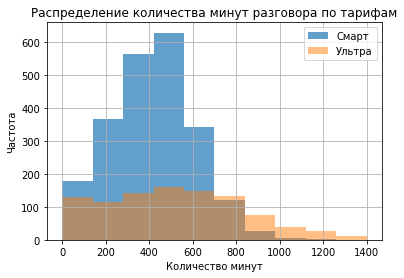

In [21]:
# Сделаем две выборки, раделенные по тарифам:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

# Построим гистограммы распределения количества минут разговоров по каждому тарифу:
data_smart['min_sum'].hist(alpha = 0.7, range = (0,1400), label="Смарт")
data_ultra['min_sum'].hist(alpha = 0.5, range = (0,1400), label="Ультра")
plt.legend()
plt.title('Распределение количества минут разговора по тарифам')
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.show()

Из гистограммы по тарифу Смарт видим, что у нас биноминальное распределение, немного скошенное вправо. Значит, медиана будет чуть меньше среднего.<br>Также из графика распределения видно, что тарифом Ультра пользуется намного меньше людей, чем тарифом Смарт. 
Из гистограммы видно, что чаще всего на тарифе Смарт пользователи тратят примерно 300-400 минут в месяц, а пользователи тарифа Ультра в широком диапазоне от 0 до 800 минут. <br> Согласно тарифам, тариф Смарт включает в себя 500 минут разговора, тогда как тариф Ультра содержит 3000 минут разговора. <br> Таким образом, можно прийти к следующим выводам:
- некоторой части тарифа Смарт приходится доплачивать за дополнительные минуты разговора, т.к. ежемесячный лимит времени на разговоры иногда превышается; 
- среди пользователей тарифа Ультра почти не встречаются абоненты, которые бы доплачивали за дополнительные минуты разговора, т.к.они с большим запасом укладываются в лимит.

In [22]:
# Посчитаем среднее, дисперсию и стандартное октлонение для количества минут разговора по тарифам:
data.pivot_table(index = ['tariff'], values = 'min_sum', aggfunc = ['mean', np.var, np.std] )

,mean,var,std
,min_sum,min_sum,min_sum
tariff,,,
smart,417.747534,36281.393836,190.476754
ultra,526.089249,101052.493549,317.887549


Пользователи тарифа Смарт в среднем разговаривают по телефону 371 минут в месяц. Это обусловлено тем, что в тариф включено лишь 500 минут. Дисперсия составляет 29 тыс минут, а стандартное отклонение - 170 минут.<br>
Пользователи тарифа Ультра в среднем разговаривают по телефону 467 минут в месяц. Причём иногда их разговоры могут достигать 1400 минут в месяц, т.к. в тариф Ультра включено 3000 минут. Дисперсия составляет 80 тыс минут, а стандартное отклонение - 283 минуты.

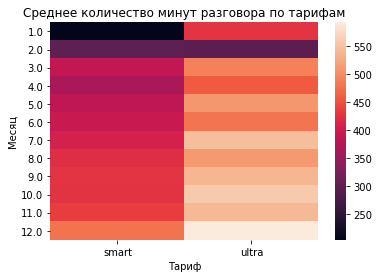

In [23]:
# Посчитаем и визуализируем среднее для количества минут разговора по месяцам:
calls_mean = data.pivot_table(index='month', columns = 'tariff', values='min_sum', aggfunc = 'mean')
sns.heatmap(calls_mean)
plt.title('Среднее количество минут разговора по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем среднее количество минут разговора в месяц растёт как для тарифа Смарт, так и для тарифа Ультра. <br>За исключением февраля пользователи тарифа Ультра в среднем разговаривают всегда больше, чем пользователи тарифа Смарт. Лишь в феврале они потратили примерно одинаковое количество минут разговора.

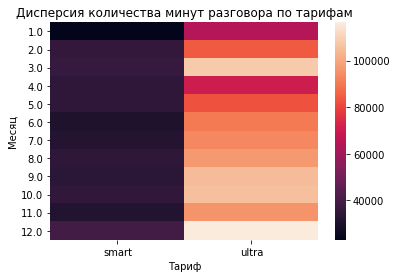

In [24]:
# Посчитаем и визуализируем дисперсию для количества минут разговора по месяцам:
calls_var = data.pivot_table(index='month', columns = 'tariff', values='min_sum', aggfunc = (lambda x: round(np.var(x),2)))
sns.heatmap(calls_var)
plt.title('Дисперсия количества минут разговора по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем дисперсия количества минут разговора в месяц также растёт для обоих тарифов. <br>Дисперсия по тарифу Ультра всегда больше, чем по тарифу Смарт.

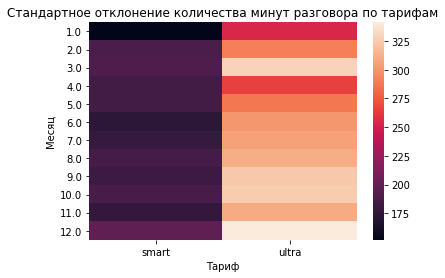

In [25]:
# Посчитаем и визуализируем стандартное отклонение для количества минут разговора по месяцам:
calls_std = data.pivot_table(index='month', columns = 'tariff', values='min_sum', aggfunc=(lambda x: round(np.std(x),2)))
sns.heatmap(calls_std)
plt.title('Стандартное отклонение количества минут разговора по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем стандартное отклонение количества минут разговора в месяц также растёт для обоих тарифов. <br>Стандартное отклонение по тарифу Ультра всегда больше, чем по тарифу Смарт.

### Количество сообщений в месяц

Определим исходя из выборки, сколько сообщений отсылают пользователи каждого тарифа в месяц.

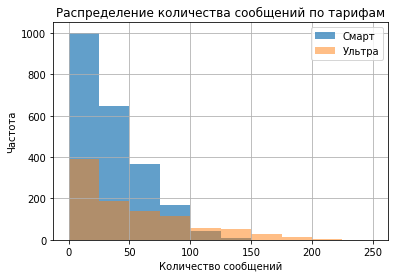

In [26]:
# Построим гистограммы распределения количества сообщений по каждому тарифу:
data_smart['messages_count'].hist(alpha = 0.7, range = (0,250), label="Смарт")
data_ultra['messages_count'].hist(alpha = 0.5, range = (0,250), label="Ультра")
plt.legend()
plt.title('Распределение количества сообщений по тарифам')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
plt.show()

В обеих гистограммах биноминальное распределение, скошенное вправо - медиана будет меньше среднего.
Пользователи тарифа Смарт в основном используют до 50 смс в месяц. Однако некоторым польхователям тарифа Смарт не хватает количества смс и им приходится перелачивать. Пользователи тарифа Ультра не переплачивают за смс, так как вполне укладываются в свой лимит 1000 смс при том, что большинство не расходует и 100 смс в месяц.

In [27]:
# Посчитаем среднее, дисперсию и стандартное октлонение для количества сообщений по тарифам:
data.pivot_table(index = ['tariff'], values = 'messages_count', aggfunc = ['mean', np.var, np.std] )

,mean,var,std
,messages_count,messages_count,messages_count
tariff,,,
smart,33.369058,796.955256,28.230396
ultra,49.313387,2285.417425,47.806040


Пользователи тарифа Смарт в среднем отсылают 33 смс в месяц. Это обусловлено тем, что в тариф включено лишь 50 смс. Дисперсия составляет 797 смс, а стандартное отклонение - 28 смс.<br>
Пользователи тарифа Ультра в среднем шлют 49 смс в месяц. Дисперсия составляет 2285 смс, а стандартное отклонение - 47 смс.

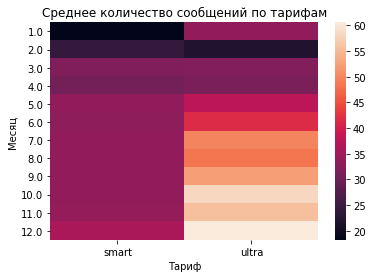

In [28]:
# Посчитаем и визуализируем среднее для количества сообщений по месяцам:
messages_mean = data.pivot_table(index='month', columns = 'tariff', values='messages_count', aggfunc = 'mean')
sns.heatmap(messages_mean)
plt.title('Среднее количество сообщений по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем среднее количество смс в месяц растёт как для тарифа Смарт, так и для тарифа Ультра. <br>За исключением февраля пользователи тарифа Ультра в среднем шлют смс всегда чаще, чем пользователи тарифа Смарт. Лишь в феврале они отослали меньшее количество смс.

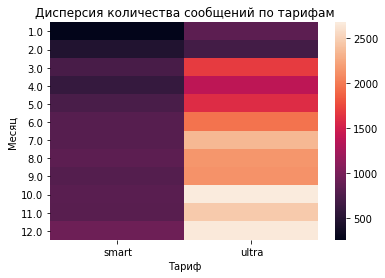

In [29]:
# Посчитаем и визуализируем дисперсию для количества сообщений по месяцам:
messages_var = data.pivot_table(index='month', columns = 'tariff', values='messages_count', aggfunc = (lambda x: round(np.var(x),2)))
sns.heatmap(messages_var)
plt.title('Дисперсия количества сообщений по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем дисперсия количества смс в месяц также растёт для обоих тарифов. <br>Дисперсия по тарифу Ультра всегда больше, чем по тарифу Смарт.

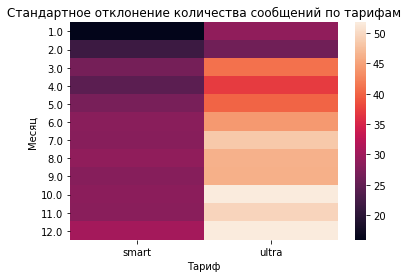

In [30]:
# Посчитаем и визуализируем стандартное отклонение для количества сообщений по месяцам:
messages_std = data.pivot_table(index='month', columns = 'tariff', values='messages_count', aggfunc=(lambda x: round(np.std(x),2)))
sns.heatmap(messages_std)
plt.title('Стандартное отклонение количества сообщений по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем стандартное отклонение количества смс в месяц также растёт для обоих тарифов. <br>Стандартное отклонение по тарифу Ультра всегда больше, чем по тарифу Смарт.

### Объём интернет-трафика в месяц

Определим исходя из выборки, сколько минут разговора требуется пользователям каждого тарифа в месяц.

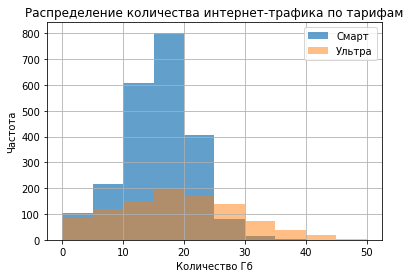

In [31]:
# Построим гистограммы распределения количества интернет-трафика по каждому тарифу:
data_smart['gb_used'].hist(alpha = 0.7, range = (0,50), label="Смарт")
data_ultra['gb_used'].hist(alpha = 0.5, range = (0,50), label="Ультра")
plt.legend()
plt.title('Распределение количества интернет-трафика по тарифам')
plt.xlabel('Количество Гб')
plt.ylabel('Частота')
plt.show()

Распределение трафика по тарифу Смарт скошено влево - медиана будет чуть больше среднего. Пользователи тарифа Смарт используют в основном от 10 до 20 ГБ в месяц, при включенном в тариф объеме интернета в 15 ГБ. Следовательно можно сделать вывод , что пользователи зачастую переплачивают.<br>
Распределение трафика по тарифу Ультра больше стремится к нормальному, но немного скошено вправо. Пользователи тарифа Ультра при включенном в 30 ГБ объема интернета, используют от 10 до 30 ГБ. 

In [32]:
# Посчитаем среднее, дисперсию и стандартное октлонение для количества интернет-трафика по тарифам:
data.pivot_table(index = ['tariff'], values = 'gb_used', aggfunc = ['mean', np.var, np.std] )

,mean,var,std
,gb_used,gb_used,gb_used
tariff,,,
smart,15.322870,33.090863,5.752466
ultra,18.486815,96.916070,9.844596


Пользователи тарифа Смарт в среднем трятят 15 Гб интернета в месяц. Это обусловлено тем, что в тариф включено лишь 15 Гб интернета в месяц. Дисперсия составляет 33 Гб, а стандартное отклонение - 5,7 Гб.<br>
Пользователи тарифа Ультра в среднем трятят 18 Гб интернета в месяц. Но есть пользователи, которые используют и до 50 ГБ интенет трафика. Дисперсия составляет 97 Гб, а стандартное отклонение - 9,8 Гб.

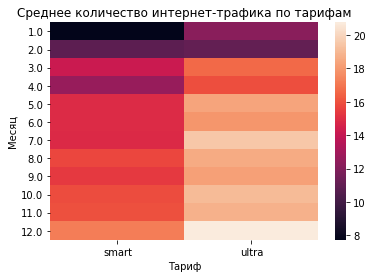

In [33]:
# Посчитаем и визуализируем среднее для количества интернет-трафика по месяцам:
gb_mean = data.pivot_table(index='month', columns = 'tariff', values='gb_used', aggfunc = 'mean')
sns.heatmap(gb_mean)
plt.title('Среднее количество интернет-трафика по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем пользователи обоих тарифов более охотно тратят интернет-трафик. <br>За исключением февраля пользователи тарифа Ультра в среднем используют больше Гб, чем пользователи тарифа Смарт.

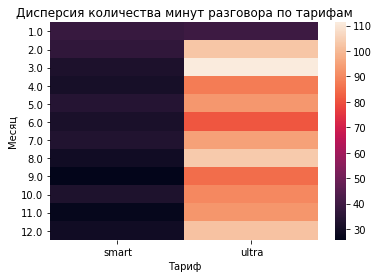

In [34]:
# Посчитаем и визуализируем дисперсию для количества интернет-трафика по месяцам:
gb_var = data.pivot_table(index='month', columns = 'tariff', values='gb_used', aggfunc = (lambda x: round(np.var(x),2)))
sns.heatmap(gb_var)
plt.title('Дисперсия количества минут разговора по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что с каждым месяцем дисперсия количества интернет-трафика в месяц также растёт для обоих тарифов. Но для тарифа Ультра растёт быстрее. <br>Дисперсия по тарифу Ультра всегда больше, чем по тарифу Смарт.

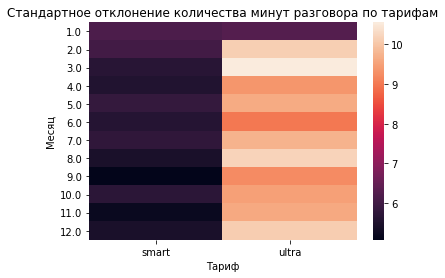

In [35]:
# Посчитаем и визуализируем стандартное отклонение для количества интернет-трафика по месяцам:
gb_std = data.pivot_table(index='month', columns = 'tariff', values='gb_used', aggfunc=(lambda x: round(np.std(x),2)))
sns.heatmap(gb_std)
plt.title('Стандартное отклонение количества минут разговора по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Месяц')
plt.show()

Из хитмэпа видно, что для обоих тарифов стандартное отклонение существенно не меняется в течение года.<br>Стандартное отклонение по тарифу Ультра всегда больше, чем по тарифу Смарт.

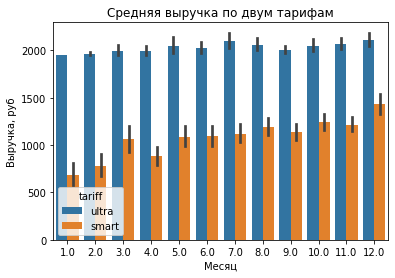

In [36]:
sns.barplot(x='month', y='sales', data=data, hue = 'tariff')
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб')
plt.title('Средняя выручка по двум тарифам')
plt.show()

In [37]:
data.pivot_table(index = ['tariff'], values = 'sales', aggfunc = 'mean' )

,sales
tariff,
smart,1172.691031
ultra,2049.645030


В среднем выручка от каждого пользователя на тарифе Смарт составила 1 172 руб в месяц при том, что цена тарифа всего 550 руб. Получается, что пользователи тарифа Смарт переплачивают в среднем 622 руб в месяц, т.е. больше, чем стоил их тариф (!) Причем переплата растет от месяца к месяцу к концу года. <br> А по тарифу Ультра средняя выручка составила 2 049 руб в месяц при том, что цена тарифа всего 1950 руб. Их переплата составляет в среднем всего 99 руб.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформируем нулевую гипотезу H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.<br>
Сформируем альтернативную гипотезу H1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.<br>
Критический уровень статистической значимости зададим alpha =0.05, чтобы вероятность правильности нашего вывода была 95% и больше.

In [38]:
sales_smart = data.query('tariff == "smart"')['sales']
sales_ultra = data.query('tariff == "ultra"')['sales']
alpha = .05
results = st.ttest_ind(
    sales_smart, 
    sales_ultra)

print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 3.0481957189513244e-226
Отвергаем нулевую гипотезу


Для выбранного уровня значимости нулевая гипотеза не подтвердилась. Следовательно можно сделать вывод, что **средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформируем нулевую гипотезу H0 - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.<br>
Сформируем альтернативную гипотезу H1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.<br>
Критический уровень статистической значимости также зададим alpha = 0.05.

In [39]:
sales_moscow = data.query('city == "Москва"')['sales']
sales_other = data.query('city != "Москва"')['sales']
from scipy import stats as st
alpha = .05
results = st.ttest_ind(
    sales_moscow, 
    sales_other)

print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.37930405825891833
Не получилось отвергнуть нулевую гипотезу


Для выбранного уровня значимости не получилось отвергнуть нулевую гипотезу. Следовательно можно сделать вывод, что **средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.**

## Вывод

Мы провели предварительный анализ тарифов Смарт и Ультра на небольшой выборке из 500 клиентов «Мегалайна». Пользователей использующих тариф Смарт в предоставленной нам выборке намного больше, чем пользователей тарифа Ультра. Мы заметили, что активность в разговорах, отправке смс и потреблении интернет-трафика пользователей обоих тарифов растёт от месяца к месяцу в течение всего года (за исключением февраля).

Проанализировав данные по пользователям, мы увидели, что люди использующие тариф Ультра в среднем совершают более длительные звонки, чаще отправляют сообщения и больше используют интернет. 

В отличие от пользователей тарифа Ультра некоторой части тарифа Смарт приходится доплачивать за дополнительные минуты разговора и дополнительные смс, т.к. ежемесячный лимит времени на разговоры и сообщения превышается. 
Значительная часть пользователей тарифа Смарт дополнительно платит и за интернет-трафик, как и некоторые пользователи тарифа Ультра. Таким образом, пользователи тарифа Смарт намного чаще переплачивают за ту или иную услугу, нежели пользователи тарифа Ультра. В среднем пользователям тарифа Смарт приходится переплачивать сумму, превышающую стоимость их тарифа, причем ближе к концу года переплата возрастала.

Тариф Ультра хорошо подходит тем пользователям, которые в основном общаются через смс и по телефону. А для пользователей которым ольше нужен хороший интернет больше подходит тариф Смарт.

Несмотря на то, что пользователи тарифа Смарт сильно переплачивают, можно сделать вывод, что пользователи, которые используют тариф Ультра, все-таки выгоднее обходятся компании, так как стоимость их тарифа больше чем в 3 раза выше стоимости тарифа Смарт, а звонков и смс они в основном тратят значительно ниже лимита. При этом, многие пользователи тарифа Ультра еще и доплачивают за интернет. А вот пользователи тарифа Смарт стараются полностью расходовать свои лимиты, а стоимость абонентской платы намного ниже.

Также при помощи p-value тестирования были проврены две гипотезы. Исходя из расчетов этих гипотез, мы можем смело утверждать следующее:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- местонахождение не влияет на уровень выручки пользователей.